In [1]:
# pip install matplotlib h5py scipy seaborn scikit-learn --no-index

In [2]:
import os, sys
from pathlib import Path
project_root = Path.cwd().parent 
# sys.path.append(str(project_##root))

BASE_DIR = Path.cwd().parent  # go up one level

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from matplotlib.colors import Normalize
# Import the analysis module
from mirrored_langevin_rnn.utils.data_pipeline.threshold_sweep_analysis import (
    load_threshold_batch_files,
    plot_threshold_heatmap,
    merge_threshold_batches
)

## Configuration

Set up the experiment configuration, including file patterns and parameters.

In [4]:
# poisson_out_dirs = [
#     BASE_DIR / "data" / "threshold_sweep" / "poisson" / "l1" / "affinity_dense_gamma",
#     BASE_DIR / "data" / "threshold_sweep" / "poisson" / "l1" / "affinity_sparse_gamma_sparsity_0.10",
#     BASE_DIR / "data" / "threshold_sweep" / "poisson" / "l1" / "affinity_sparse_binary_sparsity_0.10",
# ]
# slam_ber_out_dirs = [
#     BASE_DIR / "data" / "threshold_sweep" / "slam" / "l1" / "bernoulli" / "affinity_dense_gamma",
#     BASE_DIR / "data" / "threshold_sweep" / "slam" / "l1" / "bernoulli" / "affinity_sparse_gamma_sparsity_0.10",
#     BASE_DIR / "data" / "threshold_sweep" / "slam" / "l1" / "bernoulli" / "affinity_sparse_binary_sparsity_0.10",
# ]
slam_kum_out_dirs = [
    BASE_DIR / "data" / "threshold_sweep" / "slam" / "auc" / "kumaraswamy" / "affinity_sparse_binary_sparsity_0.10",
    BASE_DIR / "data" / "threshold_sweep" / "slam" / "auc" / "kumaraswamy" / "affinity_sparse_binary_sparsity_0.20",
    BASE_DIR / "data" / "threshold_sweep" / "slam" / "auc" / "kumaraswamy" / "affinity_sparse_binary_sparsity_0.30",
    BASE_DIR / "data" / "threshold_sweep" / "slam" / "auc" / "kumaraswamy" / "affinity_sparse_binary_sparsity_0.40",
    BASE_DIR / "data" / "threshold_sweep" / "slam" / "auc" / "kumaraswamy" / "affinity_sparse_binary_sparsity_0.50",
]

plot_combination = [
    # ("poisson_l1_binary_threshold_results_batch*.h5", poisson_out_dirs),
    # ("slam_l1_bernoulli_threshold_results_batch*.h5", slam_ber_out_dirs),
    ("slam_auc_kumaraswamy_threshold_results_batch*.h5", slam_kum_out_dirs),
]

# FILE_PATTERN = "slam_auc_bernoulli_threshold_results_batch*.h5"
# FILE_PATTERN = "slam_auc_kumaraswamy_threshold_results_batch*.h5"
# FILE_PATTERN = "poisson_rank_binary_threshold_results_batch*.h5"
# FILE_PATTERN = "poisson_rank_threshold_results_batch*.h5"

In [5]:
BATCH_SIZE = 1  

In [6]:
hide_label = True
# Save SVG to the figures directory
figures_dir = BASE_DIR / "figures" / "threshold_sweep" / "sparsity" / "auc"
if hide_label:
    figures_dir = figures_dir / "labels_hidden"
else:
    figures_dir = figures_dir / "labels_visible"
figures_dir.mkdir(parents=True, exist_ok=True)

## Visualize the Merged Threshold Sweep Results

Now we'll create a heatmap visualization of the merged grid with contour lines.

In [7]:
from pygments import highlight

selected_positions = [
    (2095, 450),  # Very high odors, high sensors
    (3031, 450),  # Maximum odors, maximum sensors
    (4387, 450),   # High odors, high sensors
]

colors = ['#FFB000', '#FE6100', '#DC267F']
#  '#d62728', '#9467bd'

def create_threshold_heatmap_plot(out_dir, file_pattern, plot_title=None, hide_axis_labels=True):
    """
    Create a threshold heatmap plot for given output directory and file pattern.
    
    Args:
        out_dir: Path to output directory containing batch files
        file_pattern: File pattern to match batch files
        n_odor_values: Number of odor values for grid
        n_sens_values: Number of sensor values for grid
        plot_title: Optional title for the plot
        hide_axis_labels: Whether to hide axis labels (default: True)
    
    Returns:
        tuple: (fig, ax, merged_grid, merged_path)
    """
    separatedColor = "#D95319"           # SLAM
    circuitColor = "#E13960"
    highlight_color = circuitColor
    
    grids, files, n_sens_values, n_odor_values = load_threshold_batch_files(
        out_dir,
        pattern=file_pattern
    )
    print(n_odor_values)
    print(n_sens_values)
    
    # Merge the grids into a complete grid using the first valid value at each position
    merged_grid, merged_path = merge_threshold_batches(
        out_dir, 
        pattern=file_pattern,
        output_file="threshold_results_merged.h5",
        merge_method="first_valid"  # Use first valid value (alternatives: "max", "min", "mean")
    )

    print(f"Processing: {out_dir}")
    print(f"Pattern: {file_pattern}")
    print(f"Merged grid shape: {merged_grid.shape}")
    print(f"Saved to: {merged_path}")

    # Count non-NaN values to check grid completeness
    non_nan_count = np.count_nonzero(~np.isnan(merged_grid))
    total_cells = merged_grid.size
    print(f"Grid completeness: {non_nan_count}/{total_cells} cells filled ({non_nan_count/total_cells:.1%})")

    # Create a figure and plot the heatmap
    fig, ax = plot_threshold_heatmap(
        merged_grid,
        n_odor_values,
        n_sens_values,
        figsize=(7,6),
        cmap="Blues",
        sigma=2,  # Gaussian smoothing parameter
        contour_levels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        highlight_level=50,
        annot=False,
        highlight_color=highlight_color  # Use the provided highlight color
    )
    ax.set_xlim([1000, 16000])
    
    # Add dots at selected positions
    for (odor_val, sens_val), color in zip(selected_positions, colors):
        ax.plot(odor_val, sens_val, 'o', color=color, markersize=16)
    
    # Configure colorbar
    norm = Normalize(vmin=5, vmax=100)
    cbar = fig.colorbar(ax.collections[0], ax=ax, shrink=0.9, aspect=9)
    cbar.mappable.set_norm(norm)
    cbar.set_ticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    cbar.ax.tick_params(width=0)
    cbar.set_ticklabels(["", '20', "", '40', "", '60', "", '80', "", '100+'], fontsize=16)
    cbar.outline.set_linewidth(2)
    
    # Add contour lines to colorbar
    contour_levels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    for level in contour_levels:
        if level == 50:
            cbar.ax.axhline(level, xmin=0.66, xmax=1, color=highlight_color, linestyle='solid', linewidth=3)
        else:
            cbar.ax.axhline(level, xmin=0.66, xmax=1, color='black', linestyle='solid', linewidth=2)
    
    cbar.ax.set_visible(not hide_axis_labels)
    
    # Apply hide_labels if requested
    if hide_axis_labels:
        ax.tick_params(labelbottom=False, labelleft=False)
        cbar.ax.set_visible(False)
    
    return fig, ax, merged_grid, merged_path

## Generate All Threshold Heatmap Plots

The following code will automatically generate threshold heatmap plots for all combinations defined in `plot_combination`. This includes:

- **3 Poisson model configurations**: dense gamma, sparse binary, sparse gamma
- **3 SLAM Bernoulli configurations**: dense gamma, sparse gamma, sparse binary  
- **3 SLAM Kumaraswamy configurations**: dense gamma, sparse binary, sparse gamma

Each plot will be saved with a descriptive filename and displayed in the notebook. The function `create_threshold_heatmap_plot()` handles the data loading, merging, visualization, and colorbar configuration for each combination.


Processing file pattern: slam_auc_kumaraswamy_threshold_results_batch*.h5
(np.int64(1000), np.int64(1203), np.int64(1447), np.int64(1741), np.int64(2095), np.int64(2520), np.int64(3031), np.int64(3647), np.int64(4387), np.int64(5278), np.int64(6350), np.int64(7639), np.int64(9190), np.int64(11055), np.int64(13300), np.int64(16000))
(np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(350), np.int64(400), np.int64(450), np.int64(500), np.int64(550), np.int64(600), np.int64(650), np.int64(700), np.int64(750), np.int64(800))
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_sparse_binary_sparsity_0.10
Pattern: slam_auc_kumaraswamy_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswam

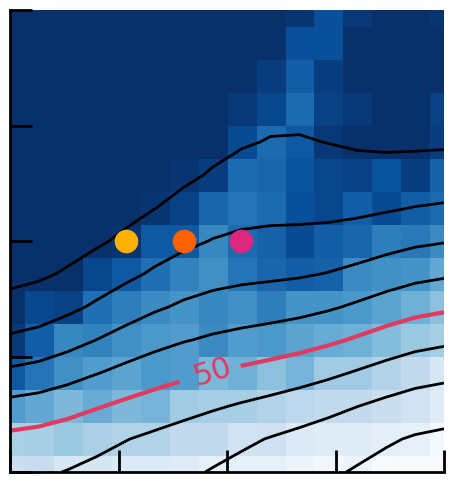


Completed 1/5 for pattern slam_auc_kumaraswamy_threshold_results_batch*.h5
(np.int64(1000), np.int64(1203), np.int64(1447), np.int64(1741), np.int64(2095), np.int64(2520), np.int64(3031), np.int64(3647), np.int64(4387), np.int64(5278), np.int64(6350), np.int64(7639), np.int64(9190), np.int64(11055), np.int64(13300), np.int64(16000))
(np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(350), np.int64(400), np.int64(450), np.int64(500), np.int64(550), np.int64(600), np.int64(650), np.int64(700), np.int64(750), np.int64(800))
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_sparse_binary_sparsity_0.20
Pattern: slam_auc_kumaraswamy_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswa

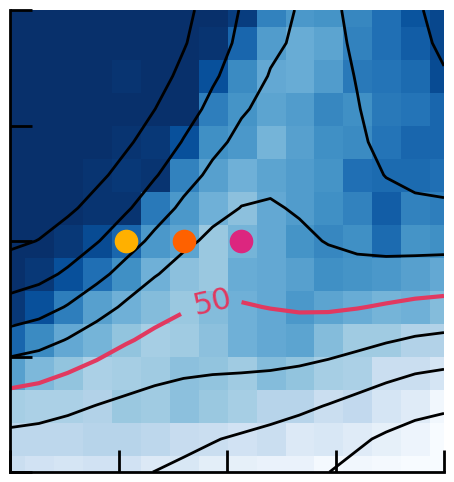


Completed 2/5 for pattern slam_auc_kumaraswamy_threshold_results_batch*.h5
(np.int64(1000), np.int64(1203), np.int64(1447), np.int64(1741), np.int64(2095), np.int64(2520), np.int64(3031), np.int64(3647), np.int64(4387), np.int64(5278), np.int64(6350), np.int64(7639), np.int64(9190), np.int64(11055), np.int64(13300), np.int64(16000))
(np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(350), np.int64(400), np.int64(450), np.int64(500), np.int64(550), np.int64(600), np.int64(650), np.int64(700), np.int64(750), np.int64(800))
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_sparse_binary_sparsity_0.30
Pattern: slam_auc_kumaraswamy_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswa

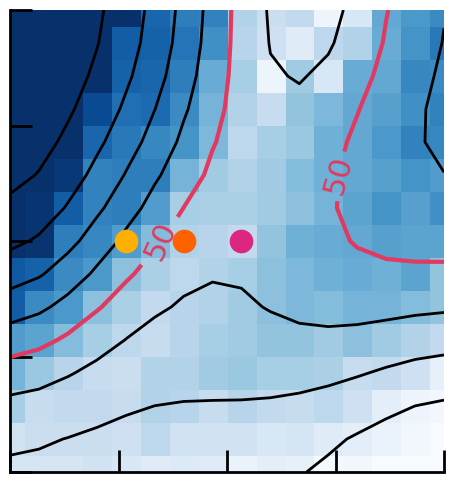


Completed 3/5 for pattern slam_auc_kumaraswamy_threshold_results_batch*.h5
(np.int64(1000), np.int64(1203), np.int64(1447), np.int64(1741), np.int64(2095), np.int64(2520), np.int64(3031), np.int64(3647), np.int64(4387), np.int64(5278), np.int64(6350), np.int64(7639), np.int64(9190), np.int64(11055), np.int64(13300), np.int64(16000))
(np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(350), np.int64(400), np.int64(450), np.int64(500), np.int64(550), np.int64(600), np.int64(650), np.int64(700), np.int64(750), np.int64(800))
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_sparse_binary_sparsity_0.40
Pattern: slam_auc_kumaraswamy_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswa

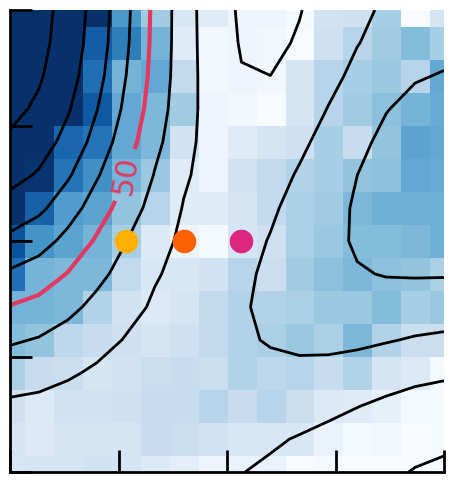


Completed 4/5 for pattern slam_auc_kumaraswamy_threshold_results_batch*.h5
(np.int64(1000), np.int64(1203), np.int64(1447), np.int64(1741), np.int64(2095), np.int64(2520), np.int64(3031), np.int64(3647), np.int64(4387), np.int64(5278), np.int64(6350), np.int64(7639), np.int64(9190), np.int64(11055), np.int64(13300), np.int64(16000))
(np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(350), np.int64(400), np.int64(450), np.int64(500), np.int64(550), np.int64(600), np.int64(650), np.int64(700), np.int64(750), np.int64(800))
Processing: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_sparse_binary_sparsity_0.50
Pattern: slam_auc_kumaraswamy_threshold_results_batch*.h5
Merged grid shape: (15, 16)
Saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswa

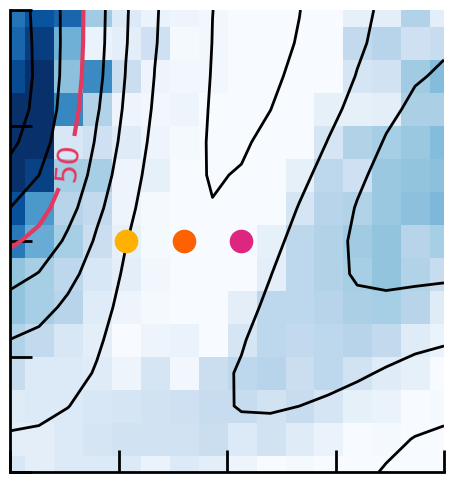


Completed 5/5 for pattern slam_auc_kumaraswamy_threshold_results_batch*.h5

All plots completed! Generated 5 plots total.


In [8]:
# Generate plots for all combinations
plot_results = []

for file_pattern, out_dirs in plot_combination:
    print(f"\n{'='*60}")
    print(f"Processing file pattern: {file_pattern}")
    print(f"{'='*60}")
    
    for i, out_dir in enumerate(out_dirs):
        # Use out_dir as the title
        plot_title = str(out_dir)
        out_dir = Path(out_dir) 
        fig, ax, merged_grid, merged_path = create_threshold_heatmap_plot(
            out_dir, 
            file_pattern, 
            plot_title=plot_title,
            hide_axis_labels=hide_label 
        )
        
        # Create filename based on directory structure
        dir_parts = str(out_dir).split('/')
        plot_filename_base = f"threshold_heatmap_{file_pattern.replace('*', '').replace('.h5', '')}_{dir_parts[-1]}"
        
        # Save PNG to the output directory
        # plt.savefig(out_dir / f"{plot_filename_base}.png", dpi=300, bbox_inches="tight")
        
        plt.savefig(figures_dir / f"{plot_filename_base}.svg", bbox_inches="tight")
        
        # Store results for later analysis if needed
        plot_results.append({
            'out_dir': out_dir,
            'file_pattern': file_pattern,
            'plot_title': plot_title,
            'merged_grid': merged_grid,
            'merged_path': merged_path,
            'plot_filename': plot_filename_base
        })
        
        plt.show()
        print(f"\nCompleted {i+1}/{len(out_dirs)} for pattern {file_pattern}")

print(f"\n{'='*60}")
print(f"All plots completed! Generated {len(plot_results)} plots total.")
print(f"{'='*60}")

## Maximum Capacity vs. Sparsity Analysis

Analyze maximum capacity values for specific grid cells (n_odors, n_sensors combinations) across different sparsity levels.

In [9]:
# Set up parameter grid
start = 1000
end = 16000 
num = 16
x_axis = tuple(sorted({int(round(x)) for x in np.logspace(np.log10(start), np.log10(end), num)}))

y_start = 100
y_end = 800
y_stepsize = 50
y_axis = tuple(range(y_start, y_end + 1, y_stepsize))

print(x_axis)
print(y_axis)

(1000, 1203, 1447, 1741, 2095, 2520, 3031, 3647, 4387, 5278, 6350, 7639, 9190, 11055, 13300, 16000)
(100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800)


In [10]:
def extract_max_capacity_for_positions(base_dirs, file_pattern, positions, sparsity_values):
    """
    Extract maximum capacity values for specific grid positions across different sparsity levels.
    
    Args:
        base_dirs: List of directory paths for different sparsity levels
        file_pattern: File pattern to match batch files
        positions: List of (n_odors, n_sensors) tuples for grid positions to analyze
        sparsity_values: List of sparsity values corresponding to base_dirs
    
    Returns:
        dict: Dictionary with position tuples as keys and max capacity arrays as values
    """
    max_capacities = {pos: [] for pos in positions}
    
    for i, out_dir in enumerate(base_dirs):
        print(f"Processing sparsity {sparsity_values[i]}: {out_dir}")
        
        try:
            # Load and merge the grids for this sparsity level
            grids, files, n_sens_values, n_odor_values = load_threshold_batch_files(
                out_dir,
                pattern=file_pattern
            )
            
            print(f"  Grid dimensions: n_odor_values={n_odor_values}, n_sens_values={n_sens_values}")
            
            merged_grid, _ = merge_threshold_batches(
                out_dir, 
                pattern=file_pattern,
                output_file=f"threshold_results_merged_sparsity_{sparsity_values[i]}.h5",
                merge_method="first_valid"
            )
            
            print(f"  Merged grid shape: {merged_grid.shape}")
            print(f"  Grid value range: {np.nanmin(merged_grid):.2f} to {np.nanmax(merged_grid):.2f}")
            
            # Use the actual coordinate values directly (they are tuples, not counts)
            n_odors_range = np.array(n_odor_values)
            n_sensors_range = np.array(n_sens_values)
            
            print(f"  n_odors range: {n_odors_range[0]} to {n_odors_range[-1]}")
            print(f"  n_sensors range: {n_sensors_range[0]} to {n_sensors_range[-1]}")
            
            # Extract values for each position
            for pos in positions:
                n_odors, n_sensors = pos
                
                # Find closest indices in the actual grid values
                odor_idx = np.argmin(np.abs(n_odors_range - n_odors))
                sens_idx = np.argmin(np.abs(n_sensors_range - n_sensors))
                
                # Get the actual coordinates
                actual_n_odors = n_odors_range[odor_idx]
                actual_n_sensors = n_sensors_range[sens_idx]
                
                max_capacity = merged_grid[odor_idx, sens_idx]
                max_capacities[pos].append(max_capacity)
                
                print(f"  Position ({n_odors}, {n_sensors}) -> grid[{odor_idx}, {sens_idx}] = "
                      f"({actual_n_odors}, {actual_n_sensors}) = {max_capacity:.2f}")
                
        except Exception as e:
            print(f"Error processing {out_dir}: {e}")
            import traceback
            traceback.print_exc()
            # Fill with NaN for failed directories
            for pos in positions:
                max_capacities[pos].append(np.nan)
    
    return max_capacities

# Define positions using exact values from the grid
# Based on the actual grid values:
# n_odors: (1000, 1203, 1447, 1741, 2095, 2520, 3031, 3647, 4387, 5278, 6350, 7639, 9190, 11055, 13300, 16000)
# n_sensors: (100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800)
# Grid shape is (15, 16), so odor index 0-14, sensor index 0-15
selected_positions = [
    (2095, 450),  # Very high odors, high sensors
    (3031, 450),  # Maximum odors, maximum sensors
    (4387, 450),   # High odors, high sensors
]

# Extract sparsity values from directory names
sparsity_values = []
for out_dir in slam_kum_out_dirs:
    dir_str = str(out_dir)
    if "sparsity_0.10" in dir_str:
        sparsity_values.append(0.10)
    elif "sparsity_0.20" in dir_str:
        sparsity_values.append(0.20)
    elif "sparsity_0.30" in dir_str:
        sparsity_values.append(0.30)
    elif "sparsity_0.40" in dir_str:
        sparsity_values.append(0.40)
    elif "sparsity_0.50" in dir_str:
        sparsity_values.append(0.50)
    else:
        sparsity_values.append(0.0)  # default for dense

print("Selected positions for analysis:")
for i, pos in enumerate(selected_positions):
    print(f"{i+1}. n_odors={pos[0]}, n_sensors={pos[1]}")

print(f"\nSparsity levels: {sparsity_values}")

# Extract the maximum capacity data
max_capacity_data = extract_max_capacity_for_positions(
    slam_kum_out_dirs, 
    "slam_auc_kumaraswamy_threshold_results_batch*.h5",
    selected_positions,
    sparsity_values
)

Selected positions for analysis:
1. n_odors=2095, n_sensors=450
2. n_odors=3031, n_sensors=450
3. n_odors=4387, n_sensors=450

Sparsity levels: [0.1, 0.2, 0.3, 0.4, 0.5]
Processing sparsity 0.1: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/threshold_sweep/slam/auc/kumaraswamy/affinity_sparse_binary_sparsity_0.10
  Grid dimensions: n_odor_values=(np.int64(1000), np.int64(1203), np.int64(1447), np.int64(1741), np.int64(2095), np.int64(2520), np.int64(3031), np.int64(3647), np.int64(4387), np.int64(5278), np.int64(6350), np.int64(7639), np.int64(9190), np.int64(11055), np.int64(13300), np.int64(16000)), n_sens_values=(np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(350), np.int64(400), np.int64(450), np.int64(500), np.int64(550), np.int64(600), np.int64(650), np.int64(700), np.int64(750), np.int64(800))
  Merged grid shape: (15, 16)
  Grid value range: 5.00 to 100.00
  n_odors range: 1000

Plot saved to: /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/figures/threshold_sweep/sparsity/auc/labels_hidden/max_capacity_vs_sparsity.svg


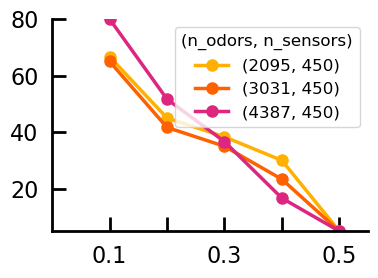


Summary Statistics:
Position (2095, 450):
  Mean capacity: 37.00
  Min capacity: 5.00
  Max capacity: 66.67
  Std deviation: 20.09
  Trend (slope): -138.33 capacity/sparsity

Position (3031, 450):
  Mean capacity: 34.00
  Min capacity: 5.00
  Max capacity: 65.00
  Std deviation: 19.88
  Trend (slope): -138.33 capacity/sparsity

Position (4387, 450):
  Mean capacity: 38.00
  Min capacity: 5.00
  Max capacity: 80.00
  Std deviation: 26.44
  Trend (slope): -185.00 capacity/sparsity



In [11]:
from mirrored_langevin_rnn.utils.visualization.styling import apply_style


def plot_max_capacity_vs_sparsity(max_capacity_data, sparsity_values, selected_positions, 
                                  figsize=(4, 3), save_path=None):
    """
    Plot maximum capacity vs. sparsity for selected grid positions.
    
    Args:
        max_capacity_data: Dictionary with position tuples as keys and capacity arrays as values
        sparsity_values: List of sparsity values
        selected_positions: List of (n_odors, n_sensors) tuples
        figsize: Figure size tuple
        save_path: Optional path to save the figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define colors for different lines
    # colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Plot each position as a separate line
    for i, pos in enumerate(selected_positions):
        capacities = np.array(max_capacity_data[pos])
        
        # Filter out NaN values
        valid_mask = ~np.isnan(capacities)
        valid_sparsity = np.array(sparsity_values)[valid_mask]
        valid_capacities = capacities[valid_mask]
        
        if len(valid_capacities) > 0:
            ax.plot(valid_sparsity, valid_capacities, 
                   marker='o', linewidth=2.5, markersize=8,
                   color=colors[i % len(colors)],
                   label=f'({pos[0]}, {pos[1]})')
    
    # Customize the plot
    # ax.set_xlabel('Sparsity Level', fontsize=14)
    # ax.set_ylabel('Maximum Capacity', fontsize=14)
    # ax.set_title('Maximum Capacity vs. Sparsity\nfor Selected Grid Positions', fontsize=16, pad=20)
    # ax.grid(True, alpha=0.3)
    ax.legend(title='(n_odors, n_sensors)', fontsize=12, title_fontsize=12)
    
    apply_style(ax)
    # Set axis limits and ticks
    ax.set_xlim(0, max(sparsity_values) + 0.05)
    ax.set_xticks(sparsity_values)
    # ax.set_xticklabels([f'{s:.1f}' for s in sparsity_values])
    ax.set_xticklabels([0.1, "", 0.3, "", 0.5])

    
    
    # Improve layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    return fig, ax

# Create the plot
fig, ax = plot_max_capacity_vs_sparsity(
    max_capacity_data, 
    sparsity_values, 
    selected_positions,
    figsize=(4, 3),
    save_path=figures_dir / "max_capacity_vs_sparsity.svg"
)

plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 50)
for pos in selected_positions:
    capacities = np.array(max_capacity_data[pos])
    valid_capacities = capacities[~np.isnan(capacities)]
    
    if len(valid_capacities) > 0:
        print(f"Position {pos}:")
        print(f"  Mean capacity: {np.mean(valid_capacities):.2f}")
        print(f"  Min capacity: {np.min(valid_capacities):.2f}")
        print(f"  Max capacity: {np.max(valid_capacities):.2f}")
        print(f"  Std deviation: {np.std(valid_capacities):.2f}")
        
        # Calculate trend (linear fit)
        if len(valid_capacities) > 1:
            valid_sparsity = np.array(sparsity_values)[~np.isnan(capacities)]
            slope, intercept = np.polyfit(valid_sparsity, valid_capacities, 1)
            print(f"  Trend (slope): {slope:.2f} capacity/sparsity")
        print()